In [5]:
!pip install transformers

import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from transformers import BertTokenizer
from tqdm import tqdm
import seaborn as sns

newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))

news = newsData['data']
topic = newsData['target']
n_topic = len(set(topic))

subjects = []
y_topic = []
for text, top in zip(news, topic):
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:      
            subject = sent[(idx + 9):].replace('Re: ', '').lower()
            subject = re.sub("[^a-zA-Z]", " ", subject)
            if len(subject.split()) > 3: 
                subjects.append(subject)
                y_topic.append(top)
            break


[[101, 19142, 100, 1998, 100, 102], [101, 100, 3980, 2000, 28363, 102], [101, 100, 2449, 2004, 5156, 102], [101, 7808, 4770, 3627, 13921, 102], [101, 2054, 2106, 23623, 5437, 2066, 102], [101, 17053, 4003, 2005, 100, 102], [101, 2053, 2455, 2005, 3521, 2053, 100, 102], [101, 2003, 100, 14639, 100, 102], [101, 4816, 100, 2001, 2109, 13154, 3160, 102], [101, 19804, 3274, 8389, 7692, 10328, 4882, 2112, 102]]
max =  29


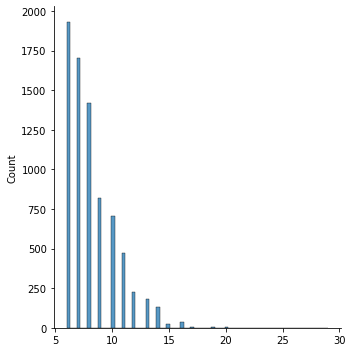

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='bert_eng_ckpt', do_lower_case=False)

subject_idx = [tokenizer.encode(s.split()) for s in subjects]
print(subject_idx[:10])

subject_len = [len(x) for x in subject_idx]
print('max = ', np.max(subject_len))
sns.displot(subject_len)

with open('/content/drive/MyDrive/news20_subject.pkl', 'wb') as f:
    pickle.dump([subjects, y_topic,subject_idx], f, pickle.DEFAULT_PROTOCOL)

In [9]:
# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

MAX_LEN = 20

def bert_tokenizer(sent):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent, 
        add_special_tokens = True,    
        max_length = MAX_LEN,           
        pad_to_max_length = True,
        return_attention_mask = True    
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']  
    
    return input_id, attention_mask, token_type_id

def build_data(doc):
    x_ids = []
    x_msk = []
    x_typ = []

    for sent in tqdm(doc):
        input_id, attention_mask, token_type_id = bert_tokenizer(sent)
        x_ids.append(input_id)
        x_msk.append(attention_mask)
        x_typ.append(token_type_id)

    x_ids = np.array(x_ids, dtype=int)
    x_msk = np.array(x_msk, dtype=int)
    x_typ = np.array(x_typ, dtype=int)

    return x_ids, x_msk, x_typ

x_train,x_test,y_train,y_test=train_test_split(subjects,y_topic,test_size=0.1)

x_train_ids, x_train_msk, x_train_typ = build_data(x_train)
x_test_ids, x_test_msk, x_test_typ = build_data(x_test)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train_ids.shape, y_train.shape, x_test_ids.shape, y_test.shape

with open('/content/drive/MyDrive/news20_train_data.pkl', 'wb') as f:
    pickle.dump([x_train_ids, x_train_msk, x_train_typ,x_test_ids, x_test_msk, x_test_typ, y_train, y_test], f, pickle.DEFAULT_PROTOCOL)

  0%|          | 0/6907 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 768/768 [00:00<00:00, 2884.40it/s]
